In [91]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 500)
import shapely.wkt
import shapely.ops
from shapely.geometry import Point
from shapely.wkt import loads 
from shapely.ops import substring
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot 
from rasterio.warp import transform
from osgeo import gdal

1 0 0 84.0
1 0 0 0 0 | 8 0.5604166666666667 0 nan
1 0 2 2 0 | 8 7.7 0 nan
1 0 20 2 0 | 6 10.219444444444443 0 nan
2 0 0 80.0
2 0 0 0 0 | 302 0.41164459161147904 12 0.22083333333333333
2 0 2 174 8 | 180 9.5125 1 29.916666666666668
2 0 20 276 8 | 170 15.383823529411764 1 29.916666666666668
3 0 0 84.0
3 0 0 0 0 | 164 1.349390243902439 0 nan
3 0 2 108 0 | 128 8.683723958333333 0 nan
3 0 20 196 0 | 93 23.634229390681003 0 nan
1 1 0 140.0
1 1 0 0 0 | 10 0.5850000000000001 0 nan
1 1 2 4 0 | 10 12.093333333333334 0 nan
1 1 20 4 0 | 8 15.041666666666666 0 nan
2 1 0 128.0
2 1 0 0 0 | 417 0.49160671462829736 44 0.45303030303030306
2 1 2 334 21 | 290 9.255172413793103 21 6.083333333333333
2 1 20 460 25 | 280 14.636071428571428 21 11.658730158730158
3 1 0 142.0
3 1 0 0 0 | 164 1.399390243902439 25 0.5446666666666666
3 1 2 111 43 | 128 8.735807291666667 39 3.80982905982906
3 1 20 196 62 | 93 23.578494623655914 20 22.938333333333333
1 2 0 200.0
1 2 0 0 0 | 24 0.7409722222222223 0 nan
1 2 2 10 0 | 24 

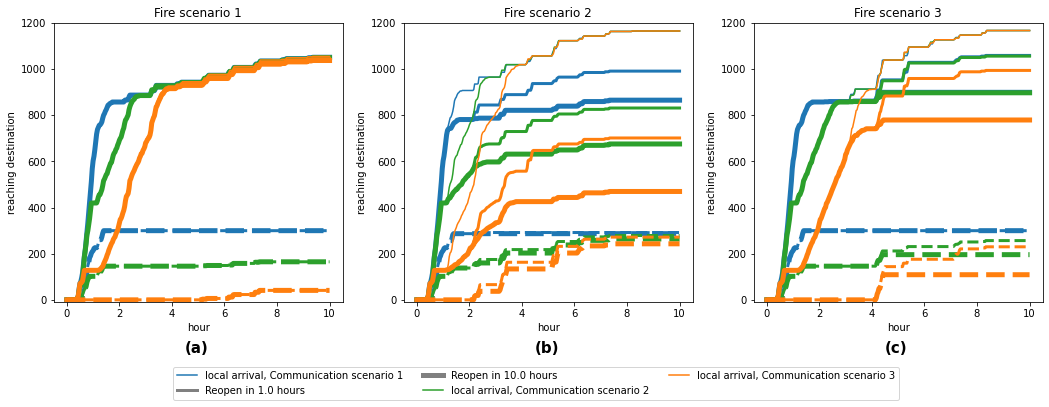

In [146]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.tight_layout(pad=3)

random_seed = 0
vphh = 2
visitor_cnts = 300
contra_id = 0
wait=1
close=0
color = iter(['C0', 'C2', 'C1'])
close_lw_dict = {0.5: 2, 2: 3, 20: 5}
wait_lw_dict = {1: 1, 10000: 3}

for comm_id in [0, 1, 2]:
    c = next(color)
    for fire_id in [1, 2, 3]:
        # if commscen != firescen-1: continue
        scen_nm = "r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}".format(random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close)
        t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
        # if comm_id==0: display(t_stats.tail(1))
            
        # print(fire_id, comm_id, 
        #       t_stats.loc[t_stats['t'].isin([3600*2, 3600*5, 3600*10]), 'arr_local'].values/1200,
        #       t_stats.loc[t_stats['t'].isin([3600*2, 3600*5, 3600*10]), 'arr_visitor'].values/300)
        # print(fire_id, comm_id, t_stats.loc[np.argmin(np.abs(t_stats['local_arr']-595*vphh*0.5)), 't']/3600)
        # print(fire_id, comm_id, t_stats.loc[np.argmin(np.abs(t_stats['visitor_arr']-300*0.5)), 't']/3600)
        # print(fire_id, comm_id, t_stats.loc[np.argmin(np.abs(t_stats['local_arr']-595*vphh*0.9)), 't']/3600)
        # print(fire_id, comm_id, t_stats.loc[np.argmin(np.abs(t_stats['visitor_arr']-300*0.9)), 't']/3600)
        print(fire_id, comm_id, close, t_stats.loc[np.argmin(np.abs(t_stats['local_arr']-800)), 't']/3600*60)
        # print(fire_id, comm_id, t_stats.loc[np.argmin(np.abs(t_stats['visitor_arr']-300*0.5)), 't']/3600)
        print(fire_id, comm_id, close, np.max(t_stats['local_shelter_a1']), np.max(t_stats['visitor_shelter_a1']), '|', t_stats['local_in_fire_cnts'].iloc[-1], (t_stats['local_in_fire_times'].iloc[-1])/(t_stats['local_in_fire_cnts'].iloc[-1])/60, t_stats['visitor_in_fire_cnts'].iloc[-1], (t_stats['visitor_in_fire_times'].iloc[-1])/(t_stats['visitor_in_fire_cnts'].iloc[-1])/60)
            
        ax[fire_id-1].plot(t_stats['t']/3600, t_stats['local_arr'], c=c, label='local arrival, Communication scenario {}'.format(comm_id+1), alpha=1)
        # ax[fire_id-1].plot(t_stats['t']/3600, t_stats['visitor_arr'], ls='--', c=c, alpha=1, label='visitor arrival, Communication scenario {}'.format(comm_id+1))
        # ax[fire_id-1].plot(t_stats['t']/3600, t_stats['in_fire_cnts'], lw=3, c=c, alpha=0.5)
        # ax[fire_id-1].plot(t_stats['t']/3600, t_stats['active1_shelter'], lw=3, c=c, alpha=1)
        # if (fire_id==2) and (comm_id==0): ax[fire_id-1].plot([], [], lw=wait_lw_dict[wait], c='gray', label='No closure')

        for close_update in [2, 20]:
        # for wait_update in [10000]:#[10000]:
            scen_nm = "r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}".format(random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close_update)
            t_stats = pd.read_csv('t_stats/t_stats_{}.csv'.format(scen_nm))
            print(fire_id, comm_id, close_update, np.max(t_stats['local_shelter_a1']), np.max(t_stats['visitor_shelter_a1']), '|', t_stats['local_in_fire_cnts'].iloc[-1], (t_stats['local_in_fire_times'].iloc[-1])/(t_stats['local_in_fire_cnts'].iloc[-1])/60, t_stats['visitor_in_fire_cnts'].iloc[-1], (t_stats['visitor_in_fire_times'].iloc[-1])/(t_stats['visitor_in_fire_cnts'].iloc[-1])/60)
            ax[fire_id-1].plot(t_stats['t']/3600, t_stats['local_arr'], lw=close_lw_dict[close_update], c=c)
            ax[fire_id-1].plot(t_stats['t']/3600, t_stats['visitor_arr'], lw=close_lw_dict[close_update], ls='--', c=c)
        #     # ax[fire_id-1].plot(t_stats['t']/3600, t_stats['in_fire_cnts'], lw=wait_lw_dict[wait_update], c=c)
            if (fire_id==2) and (comm_id==0): ax[fire_id-1].plot([], [], lw=close_lw_dict[close_update], c='gray', label='Reopen in {} hours'.format(close_update*1800/3600))

        ax[fire_id-1].set_xlabel('hour')
        ax[fire_id-1].set_ylabel('reaching destination')
        ax[fire_id-1].set_title('Fire scenario {}'.format(fire_id))
    # break
for i in range(3):
    ax[i].set_ylim([-10, 1200])
    ax[i].text(4.5, -230, '({})'.format(chr(97+i)), fontsize=15, fontweight='bold')
handles,labels = ax[1].get_legend_handles_labels()
# handles = [handles[0], handles[1], handles[2], handles[5], handles[6], handles[3], handles[7], handles[8], handles[4]]
# labels = [labels[0], labels[1], labels[2], labels[5], labels[6], labels[3], labels[7], labels[8], labels[4]]
ax[1].legend(handles,labels, loc=[-0.8,-0.35], ncol=3)
# ax[0].legend(handles,labels, loc=[0.2,-0.25], ncol=3)
# ax[2].legend(handles,labels, loc=[0.2,-0.25], ncol=3)

In [23]:
from matplotlib import cm
def plot_run_queue_fire(t, roads_gdf=None, fire_raster=None, fire_raster_extent=None, link_stats_gdf=None):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ### road network
    roads = roads_gdf.plot(ax=ax, lw=0.5, color='gray', alpha=0.5)
    ### flames
    if fire_raster is not None:
        cax = fig.add_axes([0.2, 0.2, 0.6, 0.02])
        cmap = cm.get_cmap('Oranges', 5)
        cmap.set_under(color='white', alpha=100)
        flames = ax.imshow(fire_raster.GetRasterBand(1).ReadAsArray(), extent=fire_raster_extent, cmap=cmap, vmin=0, vmax=5)
        fig.colorbar(flames, orientation='horizontal', cax=cax)
    ### queue plot
    queue_gdf = link_stats_gdf[link_stats_gdf['q']>0].copy()
    queue_gdf['geometry'] = queue_gdf.apply(lambda x: shapely.ops.substring( x['geometry'], 1-x['q']*8/(x['length']*x['lanes']), 1, normalized=True), axis=1)
    queue = queue_gdf.plot(ax=ax, lw=3, color='red')
    ### run plot
    run_gdf = link_stats_gdf[link_stats_gdf['r']>0].copy()
    run_gdf['geometry'] = run_gdf.apply(lambda x: shapely.ops.substring( x['geometry'], 0, x['r']*8/(x['length']*x['lanes']), normalized=True), axis=1)
    run = run_gdf.plot(ax=ax, lw=1, color='blue')
    (xlim_1, xlim_2) = ax.get_xlim()
    ax.set_xlim([xlim_1 + (xlim_2-xlim_1)*0.1, xlim_1 + (xlim_2-xlim_1)*0.8])
    (ylim_1, ylim_2) = ax.get_ylim()
    ax.set_ylim([ylim_1 + (ylim_2-ylim_1)*0.1, ylim_1 + (ylim_2-ylim_1)*0.6])

random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close = 0, 1, 2, 2, 300, 0, 10000, 2
t = 3600+120
scen_nm = "r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}".format(random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close)
# base network
roads_df = pd.read_csv('../network_inputs/bolinas_edges_sim.csv')
roads_gdf = gpd.GeoDataFrame(roads_df, crs='epsg:4326', geometry=roads_df['geometry'].map(loads)).to_crs(26910)
# link stats
link_stats_df = pd.read_csv('link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t))
link_stats_gdf = roads_gdf[['eid', 'length', 'lanes', 'geometry']].merge(link_stats_df, how='right', left_on='eid', right_on='link_id')
print(scen_nm)
# display(link_stats_gdf.head())
# print(link_stats_gdf.describe())
# fire
try:
    file_raster_file = "../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_f{}_h{}.tif".format(fire_id, t//3600)
    fire_raster_ds = gdal.Warp('', file_raster_file, dstSRS='EPSG:26910', format='VRT')
    referenceTrans = fire_raster_ds.GetGeoTransform()
    x_min, y_max, x_res, y_res = referenceTrans[0], referenceTrans[3], referenceTrans[1], -referenceTrans[5]  # make sure this value is positive
    x_max = x_min + x_res*fire_raster_ds.RasterXSize
    y_min = y_max - y_res*fire_raster_ds.RasterYSize
    fire_raster_extent = (x_min, x_max, y_min, y_max)
except RuntimeError:
    fire_raster_ds, fire_raster_extent = None, None
# plot
plot_run_queue_fire(t, roads_gdf=roads_gdf, fire_raster=fire_raster_ds, fire_raster_extent=fire_raster_extent, link_stats_gdf=link_stats_gdf)

FileNotFoundError: [Errno 2] No such file or directory: 'link_stats/link_stats_r0_fire1_comm2_vphh2_vistor300_contra0_wait10000_close2_t3720.csv'

In [48]:
def add_queue_length_geometry(row):
    if row['queue_proportion']==0:
        return None
    else:
        return substring(row['geometry'], 1-row['queue_proportion'], 1, normalized=True)
def add_run_length_geometry(row):
    if row['run_proportion']==0:
        return None
    else:
        return substring(row['geometry'], 0, row['run_proportion'], normalized=True)

def add_geom(rs=None, fire_id=None, comm_id=None, vphh=None, visitor_cnts=None, contra_id=None, wait=None, close=None, t=None):
    link_stats_t = pd.read_csv('link_stats/link_stats_r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}_t{}.csv'.format(rs, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close, t))
    roads_df = pd.read_csv('network/modified_network_edges_r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}.csv'.format(rs, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close))
    roads_gdf = gpd.GeoDataFrame(roads_df, crs='epsg:4326', geometry=roads_df['geometry'].map(loads)).to_crs(26910)
    link_stats_t = pd.merge(link_stats_t, roads_df[['eid', 'length', 'lanes', 'geometry']], how='left', left_on='link_id', right_on='eid')
    link_stats_t['queue_proportion'] = link_stats_t['q']*8/(link_stats_t['length']*link_stats_t['lanes'])
    link_stats_t['run_proportion'] = link_stats_t['r']*8/(link_stats_t['length']*link_stats_t['lanes'])
    link_stats_t['queue_length_geometry'] = link_stats_t.apply(add_queue_length_geometry, axis=1)
    link_stats_t['run_length_geometry'] = link_stats_t.apply(add_run_length_geometry, axis=1)
    link_stats_t.to_csv('../visualization_outputs/link_stats/link_stats_r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}_wait{}_close{}_t{}.csv'.format(rs, fire_id, comm_id, vphh, visitor_cnts, contra_id, wait, close, t))

for t in range(5280, 5640, 120):
    add_geom(rs=0, fire_id=2, comm_id=2, vphh=2, visitor_cnts=300, contra_id=0, wait=1, close=2, t=t)

In [23]:
from shapely.geometry import Point

closed_links = []
def get_road_closure(firescen=1):
    ### flame length
    flame_length = pd.read_csv(open('../demand_inputs/flamelength/flame_length_point_4326/point_firescen{}.csv'.format(firescen)))
    flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)]).to_crs('epsg:26910')
    flame_length['lon'], flame_length['lat'] = flame_length['geometry'].x, flame_length['geometry'].y
    
    for hour in range(1, 11):
        flame_length_hour = flame_length.loc[(flame_length['t_hour']==hour) & (flame_length['flame_length']>2)]
        print('fire {}, hour {}, flame point cnts {}'.format(firescen, hour, flame_length_hour.shape))
        if flame_length_hour.shape[0]==0:
            continue

        for link in links_gdf.itertuples():
            end_lon_proj, start_lon_proj, end_lat_proj, start_lat_proj = getattr(link, 'end_lon_proj'), getattr(link, 'start_lon_proj'), getattr(link, 'end_lat_proj'), getattr(link, 'start_lat_proj')
            l13 = np.vstack((flame_length_hour['lon'] - start_lon_proj, flame_length_hour['lat'] - start_lat_proj)).T
            l23 = np.vstack((flame_length_hour['lon'] - end_lon_proj, flame_length_hour['lat'] - end_lat_proj)).T
            l12 = (end_lon_proj - start_lon_proj, end_lat_proj - start_lat_proj)
            l21 = (start_lon_proj - end_lon_proj, start_lat_proj - end_lat_proj)
            ### line distance
            line_dist = np.abs(np.matmul(l13, (l12[-1], -l12[0]))) / np.linalg.norm(l12)
            ### start_dist_array
            start_node_distance = np.linalg.norm(l13, axis=1)
            start_node_angle = np.matmul(l13, l12)
            ### end_dist_array
            end_node_distance = np.linalg.norm(l23, axis=1)
            end_node_angle = np.matmul(l23, l21)
            point_line_dist = np.where(start_node_angle<0, start_node_distance,
                                        np.where(end_node_angle<0, end_node_distance, line_dist))
            if np.min(point_line_dist) < 20: ### within 20=(1.414*30/2) m of the cell centroid. Cell width ~= 30m
                closure_status = 'closed'
                closed_links.append([firescen, hour, getattr(link, 'edge_id_igraph')])

firescen=3
get_road_closure(firescen)
closed_links_df = pd.DataFrame(closed_links, columns=['firescen', 'hour', 'link_id'])
closed_links_df.to_csv('../demand_inputs/closed_links/closed_links_firescen{}.csv'.format(firescen), index=False)
closed_links_df.head()

fire 3, hour 1, flame point cnts (47, 5)


NameError: name 'links_gdf' is not defined

In [57]:
import georaster
import rioxarray

In [98]:
my_image = georaster.SingleBandRaster("../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_f{}_h{}.tif".format(fire_id, t//3600))
# plt.imshow(my_image.r, extent=my_image.extent)
my_image.extent

# rds = rioxarray.open_rasterio("../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_f{}_h{}.tif".format(fire_id, t//3600))
# plt.imshow(rds)
# rds

(-122.74640000000001, -122.59920000000001, 37.879200000000004, 37.9804)

(522271.440246478, 19.178574158378545, 0.0, 4203715.911838472, 0.0, -19.178574158378545) 677 588
(522271.440246478, 19.178574158378545, 0.0, 4203715.911838472, 0.0, -19.178574158378545)
522271.440246478 535255.3349517003 4192438.9102333453 4203715.911838472


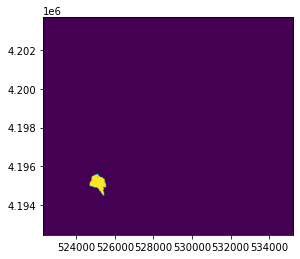

In [106]:
def plot_run_queue_fire(t, roads_gdf, fire_raster, link_stats_gdf):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ### road network
    roads = roads_gdf.plot(ax=ax, lw=0.5, color='gray', alpha=0.5)
    ### flames
    flames = rasterio.plot.show(fire_raster.read(1), ax=ax, cmap='pink')
    ### queue plot
    queue_gdf = link_stats_gdf[link_stats_gdf['q']>0].copy()
    print(queue_gdf.shape)
    queue_gdf['geometry'] = queue_gdf.apply(lambda x: shapely.ops.substring( x['geometry'], 1-x['q']*8/(x['length']*x['lanes']), 1, normalized=True), axis=1)
    queue = queue_gdf.plot(ax=ax, lw=3, color='red')

random_seed, fire_id, comm_id, vphh, vist = 0, 1, 0, 2, 300
t = 7200
scen_nm = "r{}_fire{}_comm{}_vphh{}_vistor{}_contra{}".format(random_seed, fire_id, comm_id, vphh, visitor_cnts, contra_id)
# base network
roads_df = pd.read_csv('../network_inputs/bolinas_edges_sim.csv')
roads_gdf = gpd.GeoDataFrame(roads_df, crs='epsg:4326', geometry=roads_df['geometry'].map(loads)).to_crs(26910)
# link stats
link_stats_df = pd.read_csv('link_stats/link_stats_{}_t{}.csv'.format(scen_nm, t))
link_stats_gdf = roads_gdf[['eid', 'length', 'lanes', 'geometry']].merge(link_stats_df, how='right', left_on='eid', right_on='link_id')
# fire
file_raster_file = "../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_f{}_h{}.tif".format(fire_id, t//3600)
ds = gdal.Warp('', file_raster_file, dstSRS='EPSG:26910', format='VRT')
print(ds.GetGeoTransform(), ds.RasterXSize, ds.RasterYSize)
referenceTrans = ds.GetGeoTransform()
print(referenceTrans)
x_min = referenceTrans[0]
y_max = referenceTrans[3]
x_res = referenceTrans[1]
y_res = -referenceTrans[5]  # make sure this value is positive
x_max = x_min + x_res*ds.RasterXSize
y_min = y_max - y_res*ds.RasterYSize
print(x_min, x_max, y_min, y_max)
plt.imshow(ds.GetRasterBand(1).ReadAsArray(), extent=(x_min, x_max, y_min, y_max))
# fire_raster = rasterio.open("../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_f{}_h{}.tif".format(fire_id, t//3600))
# fire_raster_26910 = rasterio.open("../demand_inputs/flamelength/flame_length_resampled_raster/flame_length_26910_f{}_h{}.tif".format(fire_id, t//3600))
# plt.imshow(ds)
# rasterio.plot.show(fire_raster)
# plot_run_queue_fire(t, roads_gdf, fire_raster, link_stats_gdf)

In [ ]:
import imageio

rs, firescen, vphh, vist = 0, 2, 2, 300
images = []
for t in range(1200, 36000, 1200):
    images.append(imageio.imread('../visualization_outputs/link_occupancy_images/rs{}_f{}_vphh{}_vist{}_t{}.png'.format(rs, firescen, vphh, vist, t)))
imageio.mimsave('../visualization_outputs/link_occupancy_images/rs{}_f{}_vphh{}_vist{}.gif'.format(rs, firescen, vphh, vist), images, fps=2)

In [13]:
rs, firescen, vphh, vist = 0, 2, 2, 300
for t in range(1200, 36000, 1200):
    fig, ax = plt.subplots(1,1, figsize=(10,20))
    for commscen in [2]:
        ### base
        roads_plot = roads_gdf.to_crs(26910).plot(ax=ax, lw=0.5, color='gray', alpha=0.5)

        ### flame
        flame_length = pd.read_csv(open('../demand_inputs/flamelength/flame_length_point_4326/point_firescen{}.csv'.format(firescen)))
        flame_length = gpd.GeoDataFrame(flame_length, crs='epsg:4326', geometry=[Point(xy) for xy in zip(flame_length.lon, flame_length.lat)])
        flame_plot = flame_length[(flame_length['t_hour']==(t//3600)) & (flame_length['flame_length']>2)].to_crs(26910).plot(ax=ax, lw=5, color='salmon', alpha=0.2)

        try:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_nodetour_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        except FileNotFoundError:
            link_stats = pd.read_csv('link_stats/link_stats_rs{}_f{}_c{}_vphh{}_vist{}_noclosure_t{}.csv'.format(rs, firescen, commscen, vphh, vist, t))
        link_stats = pd.merge(roads_gdf[['edge_id_igraph', 'length', 'geometry']], link_stats, how='inner', right_on='link_id', left_on='edge_id_igraph')
        vehs_geom = link_stats[(link_stats['q']+link_stats['r'])>0].copy()
        vehs_geom['geometry'] = vehs_geom.to_crs(26910).apply(lambda x: shapely.ops.substring( x['geometry'], 1-(x['q']+x['r'])*8/x['length'], 1, normalized=True), axis=1)
        vehs_plot = vehs_geom.plot(ax=ax, lw=3, color='purple')

        ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
        ax.set_xlim([525000, 528500])
        ax.set_ylim([4194000, 4199230])
        if t>=3600: ax.set_title("{} hr {} min; comm. scen. {}".format(t//3600, (t%3600)//60, commscen + 1), fontsize=20)
        else: ax.set_title("{} min; comm. scen. {}".format(int(t/60), commscen + 1), fontsize=20)
    plt.savefig('../visualization_outputs/link_occupancy_images/comm2_rs{}_f{}_vphh{}_vist{}_t{}.png'.format(rs, firescen, vphh, vist, t), dpi=300)
    plt.close()

/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/bingyu/anaconda3/envs/geo/lib/python3.7/site-packages/geopandas/plotting.py:487: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
